In [2]:
# in this notebook we will try to understand the grokking and double descent phenomena for simple neural networks trained 
# on a modular addition task.
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import diags
# set numpy print optins to 3 decimals
np.set_printoptions(precision=3)
plt.style.use('fivethirtyeight')



In [3]:
ns = 20
n = ns**2

# tridiagonal
k = [np.ones(n-1),1*np.ones(n),np.ones(n-1)]
offset = [-1,0,1]
A = diags(k,offset).toarray()
P = A/A.sum(axis=1)[:,None]

# double chain
# P = np.zeros((n,n))
# for i in range(n):
#     P[i,(i+1)%n] = 1/2
#     P[i,(i-1)%n] = 1/2

# circulant

# P = np.zeros((n,n))
# for i in range(n):
#     P[i,(i+1)%n] = 1


In [4]:
# gridworld
actions = np.eye(4) # up, down, left, right
# P = np.zeros((n,n))
# for i in range(n):
#     if i%10 == 0:
#         P[i,i] = 1
#     else:
#         P[i,i-1] = 1/2
#         P[i,i+1] = 1/2

In [5]:
P


array([[0.5  , 0.5  , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.333, 0.333, 0.333, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.333, 0.333, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.333, 0.333, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.333, 0.333, 0.333],
       [0.   , 0.   , 0.   , ..., 0.   , 0.5  , 0.5  ]])

In [6]:
# Let's make the dataset of states and next states
# We will use a one-hot encoding for the states



def one_hot(x, n=n):
    return np.eye(n)[x]

states = []
actions = []
next_states = []

# gridworld
toric = False
for i in range(n):
    xi, yi = i//ns, i%ns
    # uncomment for regular gridworld
    for a in range(4):
        if a == 0:
            xj, yj = xi-1, yi
        elif a == 1:
            xj, yj = xi+1, yi
        elif a == 2:
            xj, yj = xi, yi-1
        elif a == 3:
            xj, yj = xi, yi+1
        if toric:
            xj, yj = xj%ns, yj%ns
            j = xj*ns + yj
        else:
            xj = min(max(xj,0),ns-1)
            yj = min(max(yj,0),ns-1)
            j = xj*ns + yj

    # shift right for reg griworld
    
        states.append(np.hstack([one_hot(xi, ns), one_hot(yi, ns)]))
        actions.append(np.eye(4)[a])
        next_states.append(np.hstack([one_hot(xj, ns), one_hot(yj, ns)]))
        next_states.append(one_hot(j))

# # multichain world
# for i in range(n):
#     xi, yi = i//ns, i%ns
#     for a in range(4):
#         if a == 0:
#             xj, yj = xi-1, yi
#         elif a == 1:
#             xj, yj = xi+1, yi
#         elif a == 2:
#             xj, yj = xi-1, yi-1
#         elif a == 3:
#             xj, yj = (xi+1)%ns, yi+1
#         if xj >= 0 and xj < ns and yj >= 0 and yj < ns:
#             j = xj*ns + yj
#         else:
#             j = i
#         states.append(one_hot(i))
#         actions.append(np.eye(4)[a])
#         next_states.append(one_hot(j))



# random indices
indices = np.random.choice(len(states), size=len(states), replace=False)
# split into train and test
train_frac = 0.8
train_size = int(train_frac*len(states))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# make the dataset
train_states = np.array(states)[train_indices]
train_actions = np.array(actions)[train_indices]
train_next_states = np.array(next_states)[train_indices]

test_states = np.array(states)[test_indices]
test_actions = np.array(actions)[test_indices]
test_next_states = np.array(next_states)[test_indices]

# send all of them to torch on cuda
train_states = torch.tensor(train_states).float().cuda()
train_actions = torch.tensor(train_actions).float().cuda()
train_next_states = torch.tensor(train_next_states).float().cuda()

test_states = torch.tensor(test_states).float().cuda()
test_actions = torch.tensor(test_actions).float().cuda()
test_next_states = torch.tensor(test_next_states).float().cuda()

print(train_states.shape, train_actions.shape, train_next_states.shape)
print(test_states.shape, test_actions.shape, test_next_states.shape)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3200,) + inhomogeneous part.

In [ ]:
-1%25

24

In [ ]:
# we will use a simple 2 layer neural network with 10 hidden units
        
class Net2(nn.Module):
    def __init__(self, hidden_units=100):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(n, hidden_units)
        self.fca = nn.Linear(n, hidden_units)
        self.fc2 = nn.Linear(2*hidden_units,4)
        #self.fc3 = nn.Linear(hidden_units, n)

    def forward(self, x, a):
        x = torch.flatten(x, start_dim=1)

        #h = F.relu(torch.cat((self.fc1(x), self.fca(a)), dim=1))
        h = F.leaky_relu(torch.cat((self.fc1(x), self.fca(a)), dim=1))
        #h = F.leaky_relu(self.fc1(x))
        x = self.fc2(h)
        #x = F.relu(self.fc3(x))
        return x

In [ ]:
# Let's train now
net = Net2(hidden_units=50).cuda()
# initialize network parameters
for p_ in net.parameters():
    print(p_.shape)
    if p_.dim() > 1:
        nn.init.xavier_uniform_(p_)
# print number of parameters
print('number of parameters:', sum(p.numel() for p in net.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()
# optimize with weight decay
wd = 1e-5
optimizer = optim.Adam(net.parameters(), lr=0.05, weight_decay=wd)
#optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.0, weight_decay=wd)
num_epochs = 2000
train_losses = []
accuracies_train = []
accuracies_test = []
test_losses = []

for epoch in range(num_epochs):  # loop over the dataset multiple times
    net.eval()
    test_outputs = net(test_states, test_next_states)
    loss = criterion(test_outputs, test_actions)
    test_losses.append(loss.item())
    accuracies_test.append(torch.argmax(test_outputs, dim=1).eq(torch.argmax(test_actions, dim=1)).float().mean().item())

    net.train()
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    train_outputs = net(train_states, train_next_states)
    loss = criterion(train_outputs, train_actions)
    accuracies_train.append(torch.argmax(train_outputs, dim=1).eq(torch.argmax(train_actions, dim=1)).float().mean().item())
    train_losses.append(loss.item())
    

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:    # print every 100 epochs
        print(f'Epoch {epoch} | Train Loss: {train_losses[-1]:.3f} | Test Loss: {test_losses[-1]:.3f}')
        print(f'Train Accuracy: {accuracies_train[-1]:.3f} | Test Accuracy: {accuracies_test[-1]:.3f}')

torch.Size([50, 400])
torch.Size([50])
torch.Size([50, 400])
torch.Size([50])
torch.Size([4, 100])
torch.Size([4])
number of parameters: 40504


Epoch 0 | Train Loss: 0.231 | Test Loss: 0.228
Train Accuracy: 0.247 | Test Accuracy: 0.244
Epoch 100 | Train Loss: 0.063 | Test Loss: 0.387
Train Accuracy: 0.984 | Test Accuracy: 0.134
Epoch 200 | Train Loss: 0.053 | Test Loss: 0.311
Train Accuracy: 0.998 | Test Accuracy: 0.372
Epoch 300 | Train Loss: 0.053 | Test Loss: 0.311
Train Accuracy: 0.995 | Test Accuracy: 0.388
Epoch 400 | Train Loss: 0.053 | Test Loss: 0.317
Train Accuracy: 0.996 | Test Accuracy: 0.366
Epoch 500 | Train Loss: 0.053 | Test Loss: 0.315
Train Accuracy: 0.996 | Test Accuracy: 0.378
Epoch 600 | Train Loss: 0.054 | Test Loss: 0.318
Train Accuracy: 0.995 | Test Accuracy: 0.375
Epoch 700 | Train Loss: 0.054 | Test Loss: 0.314
Train Accuracy: 0.994 | Test Accuracy: 0.375
Epoch 800 | Train Loss: 0.053 | Test Loss: 0.316
Train Accuracy: 0.998 | Test Accuracy: 0.372
Epoch 900 | Train Loss: 0.053 | Test Loss: 0.316
Train Accuracy: 0.995 | Test Accuracy: 0.384
Epoch 1000 | Train Loss: 0.055 | Test Loss: 0.319
Train Accura

In [ ]:
torch.argmax(train_outputs, dim=1).eq(torch.argmax(train_actions, dim=1)).float().mean().item()

0.9945312738418579

In [ ]:
torch.argmax(train_outputs, dim=1)

tensor([3, 3, 0,  ..., 1, 0, 1], device='cuda:0')

In [ ]:
torch.argmax(train_next_states, dim=1)

tensor([377, 278, 292,  ..., 395, 337,  44], device='cuda:0')

tensor([1., 0., 0., 0.], device='cuda:0')


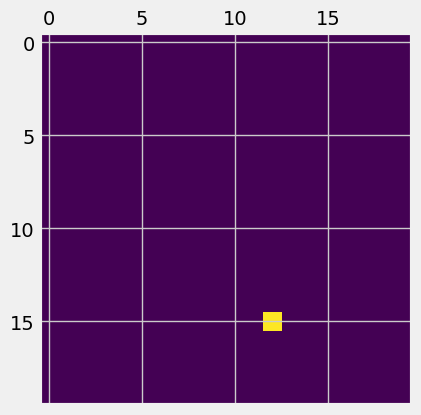

In [ ]:
i = 2
plt.matshow(train_states[i].cpu().numpy().reshape(ns,ns))
print(train_actions[i])

In [ ]:
print(F.softmax(net(train_states[i].unsqueeze(0), train_next_states[i].unsqueeze(0)), dim=1).cpu().detach().numpy())
print(train_actions[i])

[[0.484 0.187 0.159 0.17 ]]
tensor([1., 0., 0., 0.], device='cuda:0')


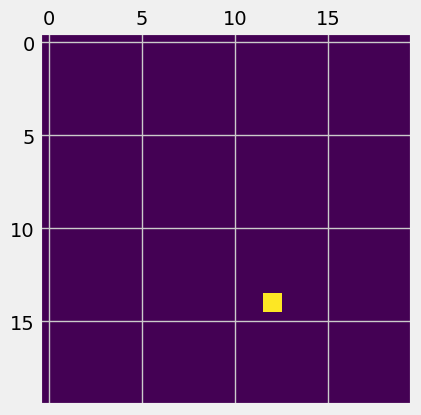

In [ ]:
plt.matshow(train_next_states[i].cpu().numpy().reshape(ns,ns))

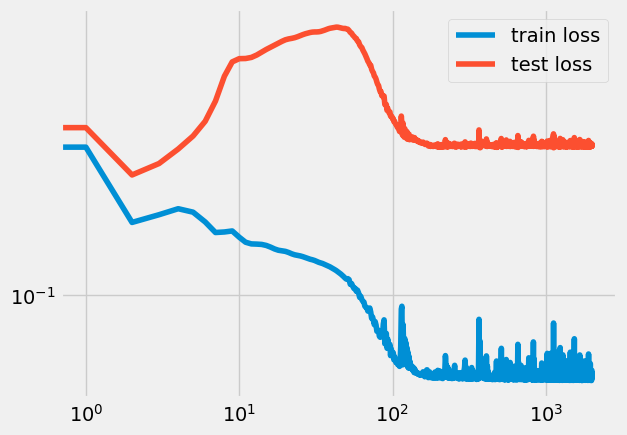

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
#plt.axhline(1/n, color='k', linestyle='--', label='random')
plt.legend()
plt.xscale('log')
plt.yscale('log')

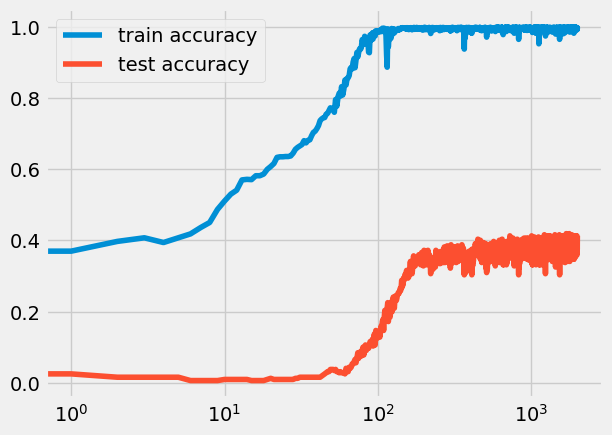

In [ ]:
plt.plot(accuracies_train, label='train accuracy')
plt.plot(accuracies_test, label='test accuracy')
plt.legend()
plt.xscale('log')


In [ ]:
torch.argmax(net(test_states, test_next_states), dim=1)

tensor([1, 1, 3, 3, 3, 3, 1, 3, 1, 0, 3, 3, 2, 2, 0, 3, 3, 3, 3, 0, 3, 0, 3, 0,
        1, 0, 1, 3, 1, 3, 3, 3, 3, 3, 0, 0, 0, 1, 0, 3, 1, 3, 0, 3, 1, 3, 0, 0,
        3, 0, 3, 0, 1, 0, 3, 3, 3, 0, 0, 3, 1, 3, 1, 3, 0, 3, 3, 3, 1, 0, 0, 2,
        3, 0, 1, 1, 0, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 0, 0, 1, 1, 3,
        0, 0, 3, 2, 1, 1, 0, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 0, 3, 1, 2,
        1, 2, 3, 1, 0, 3, 3, 3, 3, 2, 1, 2, 1, 2, 3, 3, 3, 2, 0, 1, 1, 2, 3, 1,
        1, 1, 1, 0, 3, 3, 0, 3, 3, 0, 3, 0, 3, 0, 0, 3, 3, 3, 3, 1, 0, 1, 1, 1,
        0, 1, 3, 3, 3, 2, 0, 2, 1, 3, 3, 3, 0, 0, 2, 2, 0, 0, 3, 1, 2, 1, 2, 0,
        3, 2, 2, 3, 0, 3, 0, 1, 3, 0, 3, 3, 1, 1, 2, 3, 3, 0, 1, 0, 1, 3, 3, 3,
        0, 0, 3, 0, 2, 3, 0, 1, 0, 3, 2, 2, 3, 1, 3, 3, 0, 1, 3, 1, 3, 0, 1, 0,
        3, 1, 3, 1, 3, 0, 1, 0, 0, 1, 1, 0, 0, 3, 3, 1, 0, 2, 1, 1, 2, 0, 3, 0,
        2, 0, 1, 3, 3, 0, 1, 1, 0, 2, 3, 3, 2, 0, 2, 3, 1, 0, 1, 3, 1, 0, 3, 1,
        2, 1, 2, 1, 0, 3, 0, 3, 1, 1, 0,

In [ ]:
torch.argmax(test_actions, dim=1)

tensor([2, 1, 3, 3, 0, 0, 3, 1, 2, 3, 0, 1, 2, 2, 3, 1, 0, 3, 3, 0, 3, 0, 1, 0,
        2, 2, 2, 0, 0, 3, 1, 3, 3, 1, 0, 3, 3, 2, 0, 3, 1, 3, 0, 1, 2, 0, 0, 0,
        1, 0, 1, 3, 2, 0, 3, 0, 3, 2, 2, 0, 2, 3, 2, 0, 3, 1, 3, 0, 3, 2, 2, 0,
        1, 0, 1, 1, 0, 2, 0, 1, 1, 1, 3, 1, 3, 3, 3, 0, 1, 3, 3, 2, 0, 2, 1, 0,
        2, 2, 3, 2, 1, 3, 0, 2, 1, 3, 0, 0, 2, 1, 2, 3, 1, 2, 1, 3, 3, 3, 1, 2,
        3, 2, 1, 1, 0, 1, 1, 3, 0, 1, 3, 1, 2, 2, 1, 1, 0, 2, 3, 2, 1, 2, 1, 1,
        2, 1, 1, 2, 1, 0, 2, 3, 0, 3, 0, 2, 1, 0, 2, 0, 1, 0, 1, 2, 3, 3, 1, 2,
        2, 3, 3, 3, 1, 0, 3, 2, 3, 3, 0, 0, 3, 0, 2, 1, 2, 0, 3, 1, 2, 3, 2, 2,
        0, 0, 2, 3, 0, 0, 0, 1, 3, 2, 0, 3, 1, 1, 2, 1, 3, 2, 2, 3, 1, 0, 3, 0,
        0, 0, 1, 3, 2, 1, 2, 1, 3, 2, 2, 0, 1, 0, 3, 1, 2, 2, 1, 1, 0, 0, 3, 0,
        1, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 2, 0, 1, 3, 0, 2, 1, 3, 2, 3, 3, 2,
        2, 3, 1, 0, 1, 0, 1, 3, 0, 0, 0, 0, 0, 0, 2, 0, 2, 3, 3, 1, 2, 3, 0, 2,
        2, 1, 2, 2, 0, 1, 2, 2, 3, 1, 3,

In [ ]:
# extract weights of the network
weights = []
biases = []
for p_ in net.parameters():
    if p_.dim() > 1:
        weights.append(p_.detach().cpu().numpy())
    else:
        biases.append(p_.detach().cpu().numpy().flatten())
    

In [ ]:
len(weights)

3

In [ ]:
for i in range(len(weights)):
    print(weights[i].shape)

(50, 400)
(50, 400)
(4, 100)


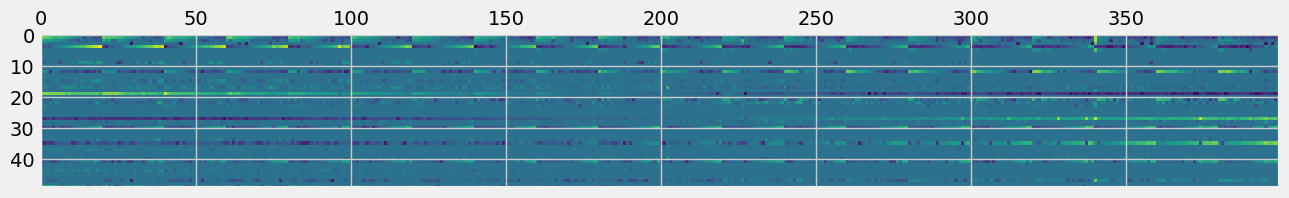

In [ ]:
plt.matshow(weights[0])

In [ ]:
#plt.matshow(weights[1])

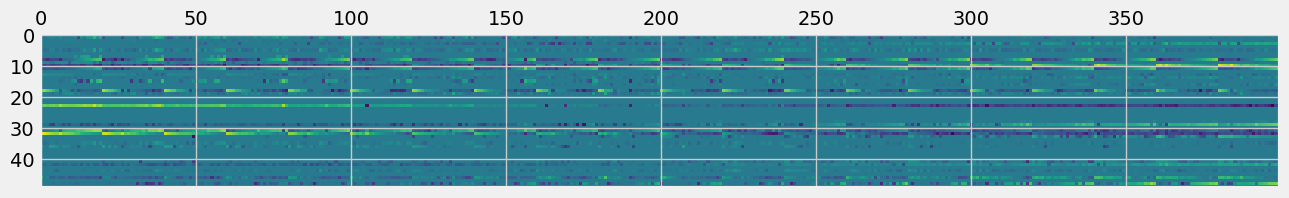

In [ ]:
plt.matshow(weights[1])

In [ ]:
# eigenvalues of P
eigvals, eigvecs = np.linalg.eig(P)
print(eigvecs.shape)

(400, 400)


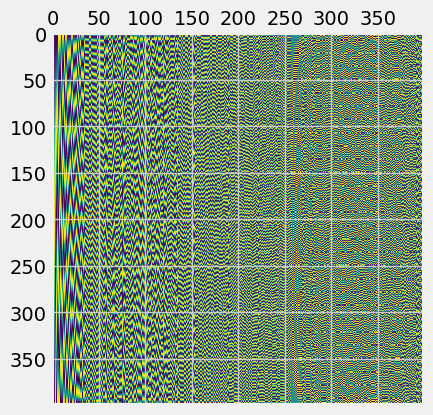

In [ ]:

plt.matshow(np.real(eigvecs))

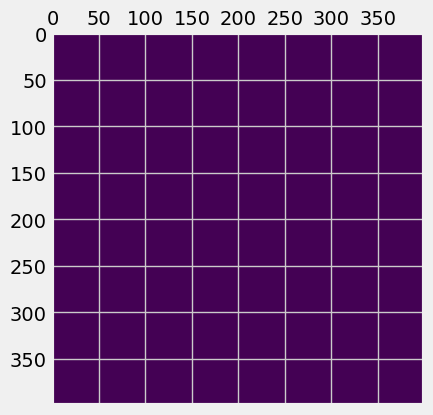

In [ ]:

plt.matshow(np.imag(eigvecs))

In [ ]:
for i in range(9):
    plt.plot(weights[0][i], alpha=0.5)

NameError: name 'plt' is not defined

In [ ]:
# let's compute the fourier transform of the weights
from scipy.fftpack import fft, fftfreq
fft_weights = fft(weights[0], axis=1)

In [ ]:
fft_weights.shape

(50, 400)

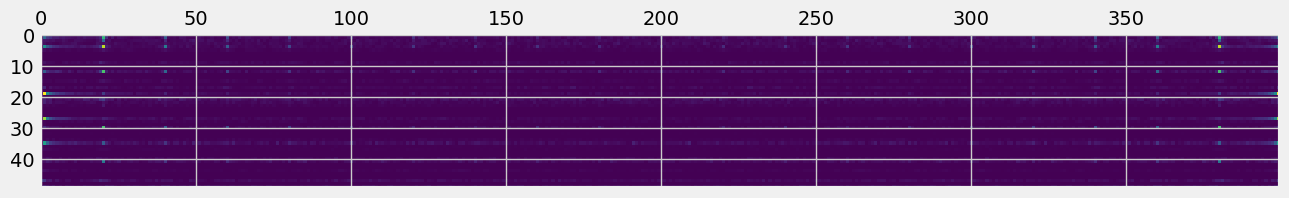

In [ ]:
plt.matshow(np.abs(fft_weights))

In [ ]:
# Let's compute the normalized power on each dimension
power = np.abs(fft_weights)**2
print(power.shape)

(50, 400)


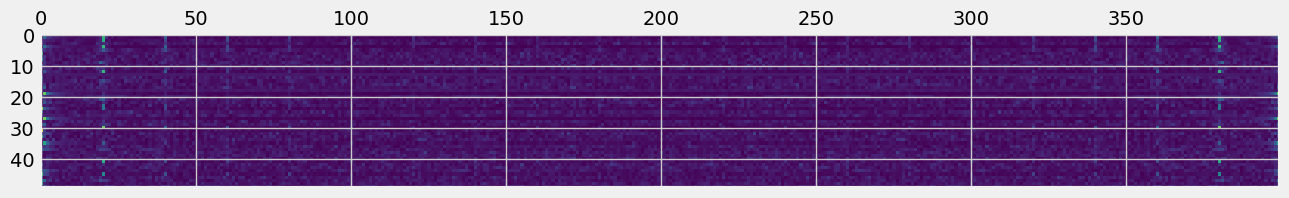

In [ ]:
plt.matshow(np.abs(fft_weights)/np.sqrt(power.sum(axis=1, keepdims=True)))

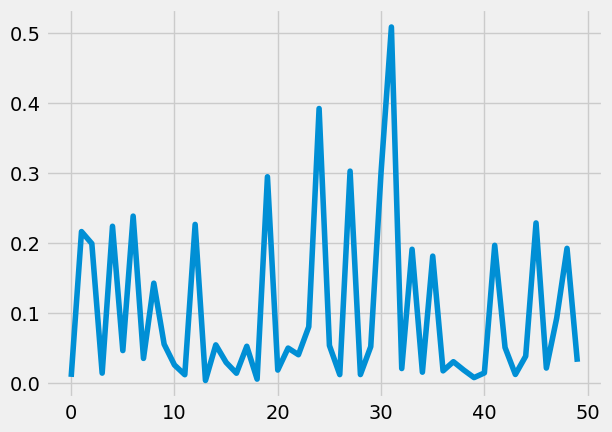

In [ ]:
normalized_power = np.max(power/power.sum(axis=1, keepdims=True), axis=1)
plt.plot(normalized_power)

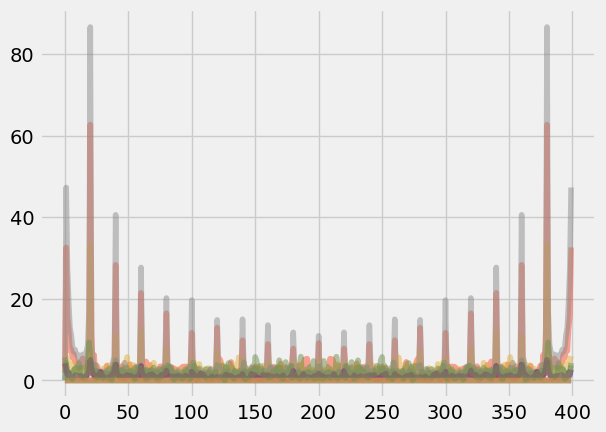

In [ ]:
for i in range(10):
    plt.plot(np.abs(fft_weights[i]), alpha=0.5)

In [ ]:
biases[0].shape

(50,)

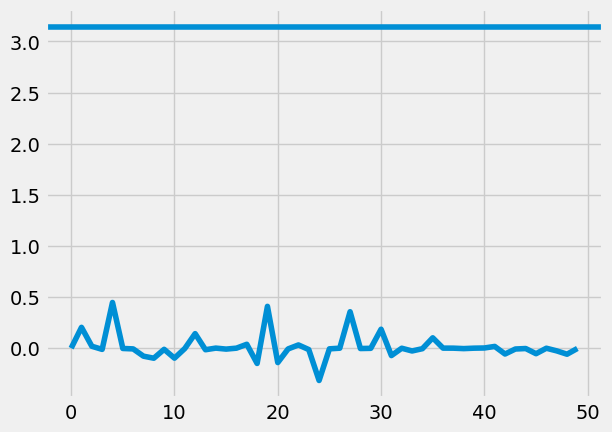

In [ ]:
plt.plot(biases[0])
plt.axhline(np.pi)

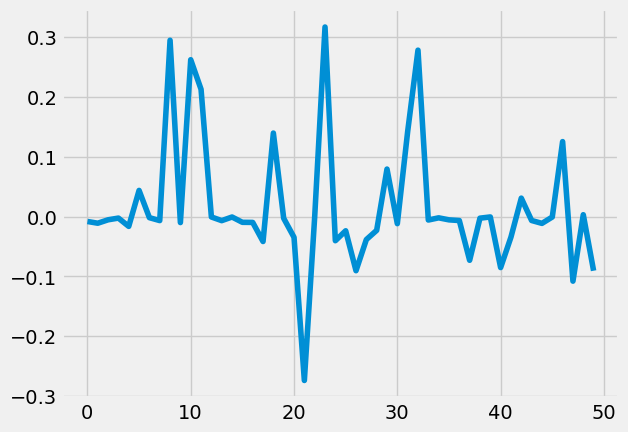

In [ ]:
plt.plot(biases[1])

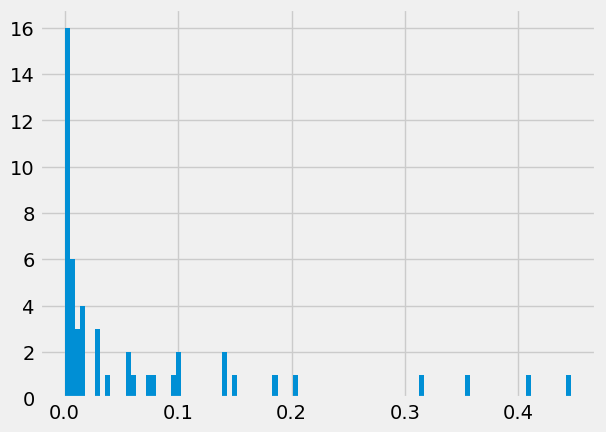

In [ ]:
res = plt.hist(np.abs(biases[0]), bins=100)

In [ ]:
res[0]

array([16.,  6.,  3.,  4.,  0.,  0.,  3.,  0.,  1.,  0.,  0.,  0.,  2.,
        1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [ ]:
res[1]

array([2.575e-04, 4.719e-03, 9.180e-03, 1.364e-02, 1.810e-02, 2.256e-02,
       2.703e-02, 3.149e-02, 3.595e-02, 4.041e-02, 4.487e-02, 4.933e-02,
       5.380e-02, 5.826e-02, 6.272e-02, 6.718e-02, 7.164e-02, 7.610e-02,
       8.056e-02, 8.503e-02, 8.949e-02, 9.395e-02, 9.841e-02, 1.029e-01,
       1.073e-01, 1.118e-01, 1.163e-01, 1.207e-01, 1.252e-01, 1.296e-01,
       1.341e-01, 1.386e-01, 1.430e-01, 1.475e-01, 1.519e-01, 1.564e-01,
       1.609e-01, 1.653e-01, 1.698e-01, 1.743e-01, 1.787e-01, 1.832e-01,
       1.876e-01, 1.921e-01, 1.966e-01, 2.010e-01, 2.055e-01, 2.099e-01,
       2.144e-01, 2.189e-01, 2.233e-01, 2.278e-01, 2.323e-01, 2.367e-01,
       2.412e-01, 2.456e-01, 2.501e-01, 2.546e-01, 2.590e-01, 2.635e-01,
       2.679e-01, 2.724e-01, 2.769e-01, 2.813e-01, 2.858e-01, 2.903e-01,
       2.947e-01, 2.992e-01, 3.036e-01, 3.081e-01, 3.126e-01, 3.170e-01,
       3.215e-01, 3.259e-01, 3.304e-01, 3.349e-01, 3.393e-01, 3.438e-01,
       3.483e-01, 3.527e-01, 3.572e-01, 3.616e-01, 

In [ ]:
def train(num_epochs=10000, hidden_units=100, wd=1e-4, verbose=False):
    # Let's train now
    net = Net2(hidden_units=hidden_units).cuda()
    # initialize network parameters
    for p_ in net.parameters():
        if p_.dim() > 1:
            nn.init.xavier_uniform_(p_)
    # print number of parameters
    print('number of parameters:', sum(p.numel() for p in net.parameters() if p.requires_grad))

    criterion = nn.CrossEntropyLoss()
    # optimize with weight decay
    #optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0, weight_decay=1e-3)
    optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=wd)
    num_epochs = num_epochs
    train_losses = []
    accuracies_train = []
    accuracies_test = []
    test_losses = []
    all_weigths = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        net.train()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(train_dataset)
        loss = criterion(outputs, train_labels)

        accuracies_train.append(torch.argmax(outputs, dim=1).eq(torch.argmax(train_labels, dim=1)).float().mean().item())

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_losses.append(running_loss)
        net.eval()
        outputs = net(test_dataset)
        loss = criterion(outputs, test_labels)
        test_losses.append(loss.item())
        accuracies_test.append(torch.argmax(outputs, dim=1).eq(torch.argmax(test_labels, dim=1)).float().mean().item())

        #all_weigths.append([p_.detach().cpu().numpy() for p_ in net.parameters()])

        if epoch % 100 == 0 and verbose:    # print every 100 epochs
            print('[%d] train loss: %.3f, test loss: %.3f' %
                  (epoch + 1, train_losses[-1], test_losses[-1]))
    return train_losses, test_losses, accuracies_train, accuracies_test, all_weigths

In [ ]:
# train multiple networks with different hidden sizes
from tqdm import tqdm

#hidden_units = [10, 20, 30, 50, 60, 70, p, 80, 100, 130, 140, 2*p, 150, 200, 500, 1000, train_dataset.shape[0], p**2]
hidden_units = [10, 60, 70, p, 72, 80, 130, 140, 2*p, 144, 150, 1000, train_dataset.shape[0], p**2, 3*p**2]
# log scale hiden units
hidden_units = [int(h) for h in np.logspace(1, 4, 15)]
all_train_losses = []
all_test_losses = []
all_accuracies_train = []
all_accuracies_test = []
all_all_weights = []

for hidden_unit in tqdm(hidden_units):
    print(f'hidden_units={hidden_unit}')
    train_losses, test_losses, accuracies_train, accuracies_test, all_weights = train(num_epochs=10000, hidden_units=hidden_unit)
    all_train_losses.append(train_losses)
    all_test_losses.append(test_losses)
    all_accuracies_train.append(accuracies_train)
    all_accuracies_test.append(accuracies_test)
    all_all_weights.append(all_weights)

NameError: name 'p' is not defined

Text(0, 0.5, 'Test loss')

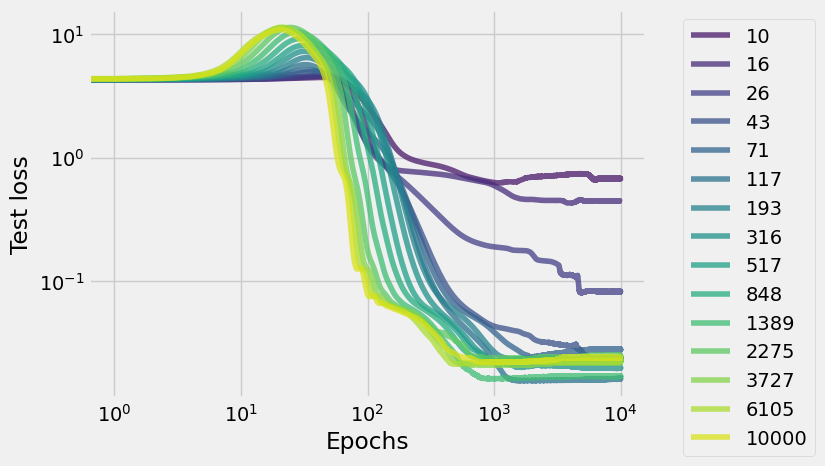

In [ ]:
# let's plot all the train and test losses
# let's use cyclic color palette with a viridis colormap
n = len(hidden_units)
colors = sns.color_palette('viridis', n_colors=n)

for i in range(n):
    plt.plot(all_test_losses[i], label=f'{hidden_units[i]}', color=colors[i], alpha=0.75)
# legend outside of the figure
plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Test loss')

(0.005, 1)

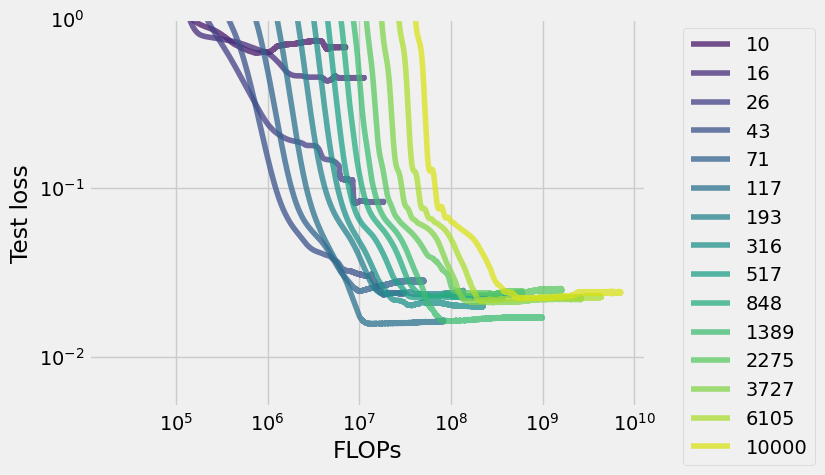

In [ ]:
# No let's do the plot with the FLOPs on the x-axis
# let's plot the test loss on the y axis

# let's compute the number of FLOPs
# we have 2 matrix multiplications and 2 matrix additions per layer
# the first layer has 2*p*hidden_units parameters
# the second layer has hidden_units*p parameters
# the total number of FLOPs at time t is then
# O(t*hiddent_units*p)
# we will ignore the bias terms and the batch size is constant
# we will also ignore the activation functions

n = len(hidden_units)
T = len(all_test_losses[0])
flops = np.zeros((n, T))
for i in range(n):
    for t in range(T):
        flops[i, t] = hidden_units[i]*p*t

# Let's plot each curve (for a given hidden size) with a viridis colorscheme
for i in range(n):
    plt.plot(flops[i, 30:], all_test_losses[i][30:], label=f'{hidden_units[i]}', color=colors[i], alpha=0.75)
plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('FLOPs')
plt.ylabel('Test loss')
plt.ylim([5e-3, 1])

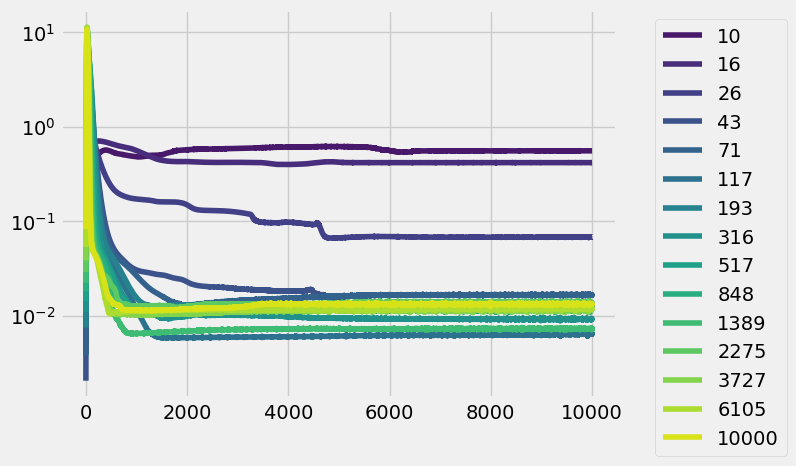

In [ ]:
# Same with the generalization gap now
for i in range(n):
    plt.plot(np.array(all_test_losses[i])-np.array(all_train_losses[i]), label=f'{hidden_units[i]}', color=colors[i])
# legend outside of the figure
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

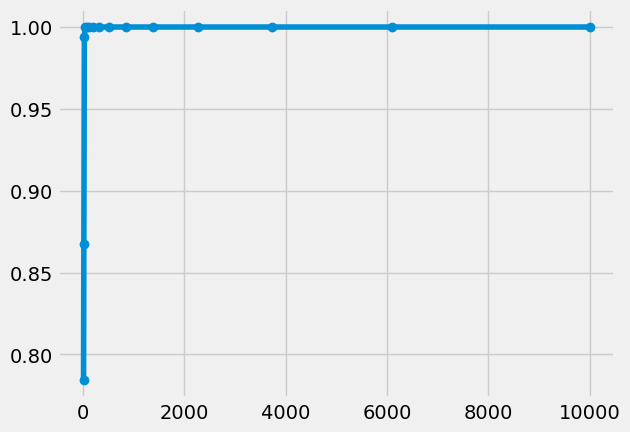

In [ ]:
# Let us now plot the final test accuracy as a function of the number of hidden units
final_accuracies_test = [all_accuracies_test[i][-1] for i in range(n)]
plt.plot(hidden_units, final_accuracies_test, 'o-')

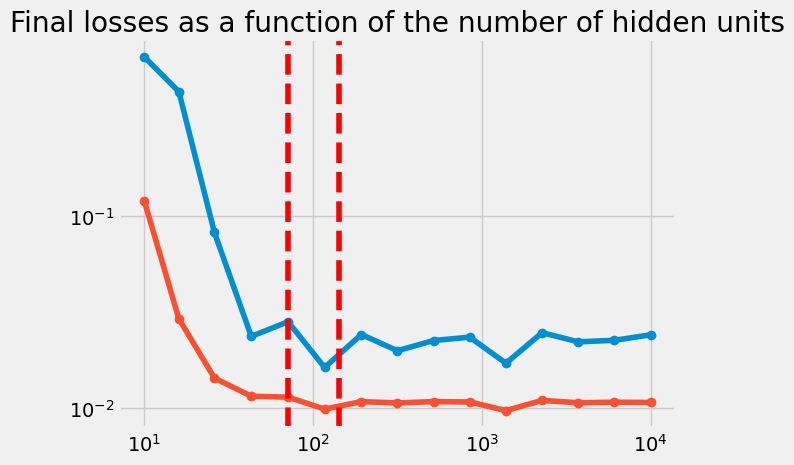

In [ ]:

final_loss_test = [all_test_losses[i][-1] for i in range(n)]
final_loss_train = [all_train_losses[i][-1] for i in range(n)]
plt.plot(hidden_units, final_loss_test, 'o-')
plt.plot(hidden_units, final_loss_train, 'o-')
plt.yscale('log')
plt.xscale('log')
plt.title('Final losses as a function of the number of hidden units')
plt.axvline(p, color='r', linestyle='--')
plt.axvline(2*p, color='r', linestyle='--')

([<matplotlib.axis.XTick at 0x7fb195a1f160>,
 [Text(0, 0, '10'),
  Text(1, 0, '16'),
  Text(2, 0, '26'),
  Text(3, 0, '43'),
  Text(4, 0, '71'),
  Text(5, 0, '117'),
  Text(6, 0, '193'),
  Text(7, 0, '316'),
  Text(8, 0, '517'),
  Text(9, 0, '848'),
  Text(10, 0, '1389'),
  Text(11, 0, '2275'),
  Text(12, 0, '3727'),
  Text(13, 0, '6105'),
  Text(14, 0, '10000')])

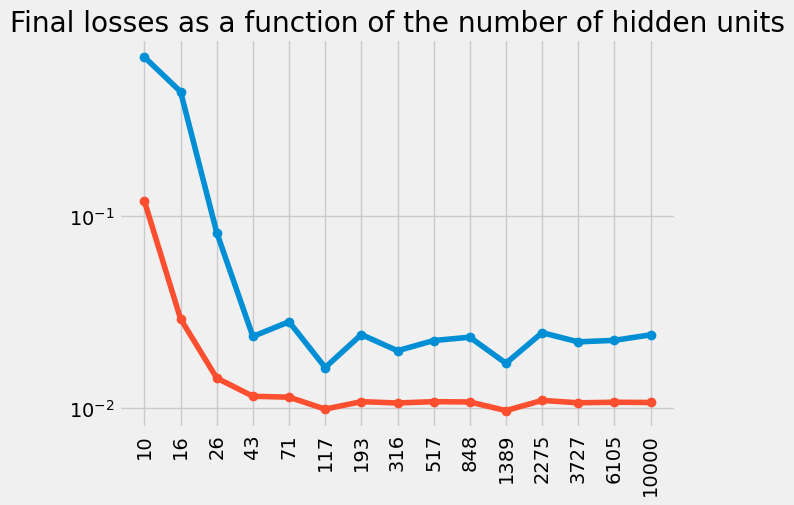

In [ ]:

plt.plot(np.arange(n), final_loss_test, 'o-')
plt.plot(np.arange(n), final_loss_train, 'o-')
plt.yscale('log')
plt.title('Final losses as a function of the number of hidden units')
# and use hidden units for the x axis with set_xticks
plt.xticks(np.arange(n), hidden_units, rotation=90)

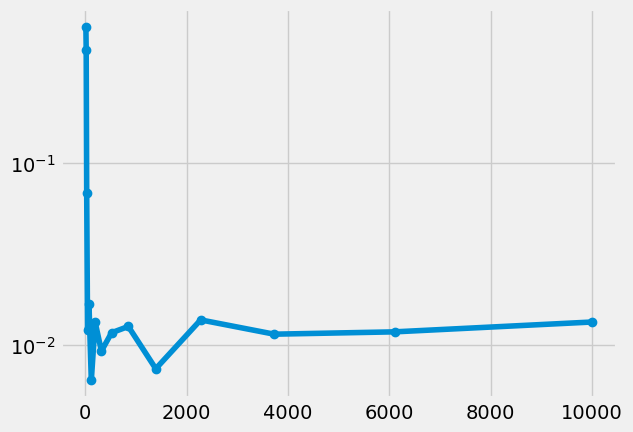

In [ ]:
# we plot the final generalization gap as a function of the number of hidden units
final_loss_test = [all_test_losses[i][-1] for i in range(n)]
final_loss_train = [all_train_losses[i][-1] for i in range(n)]
plt.plot(hidden_units, np.array(final_loss_test)-np.array(final_loss_train), 'o-')
plt.yscale('log')

In [ ]:
all_all_weight_np = np.array(all_all_weights)